# solving the convection-diffusion-reaction problem with Galerkin method:

in this work we are going to solve the following boundary value problem: \
$-\epsilon\nabla . (A\nabla u) + \textbf{b} . \nabla u + cu = S$ in $\Omega$ \
with $u = u_B$ on $\partial\Omega_D$ and $\textbf{n}.A\nabla u + \theta u = g_B$ on $\partial\Omega_N$ \
known as the ***convection-diffusion-reaction equation***.\
\
to do this we turn to the weak formulation of the problem which goes as:\
$\text{find }u\in H^1\text{ such that }u = u_B\text{ on }\partial\Omega_D\text{ and }B(u, v) = l(v) ; \ \forall v\in H_0^1(\Omega) $\
where $B$ and $l$ are defined as:\
$B(u, v) = (\epsilon A\nabla u - \textbf{b}u, \nabla v) + ([c - \nabla.\textbf{b}]u, v) + \int_{\partial\Omega_N} [\epsilon\theta + \textbf{b.n}]uvd\Gamma$\
$l(v) = (S, v) + \epsilon\int_{\partial\Omega_N} g_Bvd\Gamma$\
but in the $\textit{Galerkin method}$ here insted of solving this equation in $H^1$ we solve it in a finite-dimensional subspace $S^h$ to get an approximation $U$ to the unknown function $u$.\
first if we assume that $\tilde{u}_B$ is an extension of $u_B$ to $\bar{\Omega}$ and that $\{\phi_i\}_{i = 1}^{N}$ is a basis for $S_0^h$ then the problem would be to finde $\{U_i\}_{i = 1}^{N}$ such that with:\
$U = \tilde{u}_B + \Sigma_{i = 1}^N U_i\phi_i$\
we have:\
$B(U, \phi_j) = l(\phi_j) \ j = 1, ..., N$\
so the vector of our unknown coefficients $\textbf{U}$ would have to satisfy the linear equation $\textbf{KU = F}$ where:\
$K_{i, j} = B(\phi_i, \phi_j)$ and $F_j = l(\phi_j) - B(\tilde{u}_B, \phi_j)$

so our task now would be to finde suitable basis functions $\{\phi_i\}_{i = 1}^j$ and then to use them to form the matrices $\textbf{K, F}$ and ultimately solve for $\textbf{U}$.\
the idea is to partition $\Omega$ into polygonal elements(only triangular and Quadrilateral elements are being considered here) and then take $S^h$ to be the space of all continuous functions that are of some specified form of polunomials on each element(here we consider linear and quadratic polynomials on triangles and bilinear and biquadratic polynomials on squares).

the following code solves the $\textit{convection-diffusion-reactio equation}$ on the rectangular region $[-1, 1]\times [0, 1]$ with $A = I$, $\textbf{b} = (2y(1 - x^2), -2x(1 - y^2))$, $c = 0$, $S = 0$ and $[0, 1]\times \{0\}$ as the Neumann boundary with $\theta = 0$, $g_B = 0$ and the rest of the rectangle's boundary as Dirichlet boundary with $u_B$ taken to be of the form $1 + \tanh{(1 + constant (2x + 1))}$ on $[-1, 0]\times {0}$ and $1 - \tanh{(constant)}$ on the rest of the Dirichlet boundary for some given constant(we took it to be 10).\
we shall explain what each block of our code does as we go through them.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

## difining the problem:

In [2]:
dim = 2

In [3]:
def A(global_coordinates):
    return np.identity(dim)

In [4]:
def b(global_coordinates):
    x, y = global_coordinates
    return np.array([2 * y * (1 - x ** 2), 
                    -2 * x * (1 - y ** 2)])

In [5]:
def C(global_coordinates):
    return 0

In [6]:
def div_b(global_coordinates):
    return 0

In [7]:
def S(global_coordinateres):
    return 0

In [8]:
theta = 0
def g_B(global_coordinates):
    return 0

In [9]:
constant = 10
def u_B(global_coordinates):
    x, y = global_coordinates
    if x > 0:
        x *= -1
    return (1 + np.tanh(constant * (2 * x + 1))) * (1 - y) + (1 - np.tanh(constant)) * y

def grad_u_B(global_coordinates):
    x, y = global_coordinates
    if x > 0:
        x *= -1
        return np.array([-2 * constant / np.cosh(constant * (2 * x + 1)) ** 2,\
                         -(np.tanh(constant * (2 * x + 1)) + np.tanh(constant))])
    else:
        return np.array([2 * constant / np.cosh(constant * (2 * x + 1)) ** 2 * (1 - y),\
                         -(np.tanh(constant * (2 * x + 1)) + np.tanh(constant))])

In [10]:
def on_Dirichlet_Boundary(global_coordinates):
    if (global_coordinates[1] == 0 and -1 < global_coordinates[0] <= 0) or\
        (global_coordinates[1] == 1 and -1 < global_coordinates[0] < 1):
        return True
    elif (global_coordinates[0] == -1 or global_coordinates[0] == 1) and\
        (0 <= global_coordinates[1] <= 1):
        return True
    else:
        return False


def on_Neumann_Boundary(global_coordinates):
    if global_coordinates[1] == 0 and 0 <= global_coordinates[0] <= 1:
        return True
    else:
        return False
    
def outward_unit_perpendicular_to_Neumann_boundary(global_coordinates):
    return np.array([0, -1])

## the solution process:

in the function ```initial_definitions``` we define some functions and variables that will be usefull throughout our implimentation and we store them in a dictionary as described bellow:
1. ```get_elements```: a function that given the specified number of divisions along each axis, would yield:
    1. the list consisting of a representation of all the elements, consisting of a the coordinates of the vertices of the element and the indices of all its edges on the Neumann boundary. each form of partitioning the region has its owen specified element shape and each element shape has a rference element for triangular elements it is the right angle triangle with vertices on $(0, 0), (1, 0), (0, 1)$ and for Quadrilateral elements its a rectangule with vertices on $(-1, -1), (1, -1), (1, 1), (-1, 1)$ indexed from zero in a counterclockwise manner and the edges would be indexed the same with the zeroth edge being the one that linkes the zeroth vertex to the first and so on.
    2. the total number of elements
    3. and another function, that given a point on the region, yields the index of an element that includes it.
    
2. ```get_start_end_edge_on_reference_element```: the present function takes the edge index and yields the coordinates of the starting and the ending vertices in the reference element.

3. ```get_transform```: this is a function that given the local coordinates $\xi, \eta$ on the reference element yields the coordinates of the corresponding point on the region on a given element.

4. ```get_inverse_transform```: this function takes the coordinates of a point on the region and the vertices of the element that includes it to yield the corresponding local coordinates in the reference element.

5. ```get_Jacobian```: this function yields the Jacobian of the transformation defined by ```get_transform```.

6. ```get_integrate```: this yields the integral of a given function on the reference element(we use scipy to do these integrations).

7. ```get_points_per_element```: a polynomial on a given element would be specified by its value on certain ponts on the element, this gives the number of these points.

8. ```get_points_per_element_boundary```: this gives the number of these points that are on the boundary of the element. note that to simplify the implimentation we index these point first and then we index those on the interior of the element.

9. ```get_N```: corresponding to each of the points that determine the polynomial on the element there exists a polynomial that attains the value 1 on that point and zero on the others over the reference element. this variable is a list of these premitive polynomials.

10. ```get_grad_N```: to simplify things, we store the gradiant of each of the aforementioned premitive polynomials aswell.

11. ```get_local_edge_node_coordinates```: this is a list of local coordinates of each of these points that are on the boundary of the reference element.

In [11]:
def initial_definitions(mesh_type, function_type):
    result = dict()
    if mesh_type == 'Triangular':
        def get_triangular_elements(n_x, n_y):
            h_x = 2 / n_x
            h_y = 1 / n_y
            my_elements = []
            count = 0
            for j in range(n_y):
                for i in range(n_x):
                    my_element_1 = []
                    my_element_1.append(np.array([[i * h_x - 1, j * h_y],
                                                 [(i + 1) * h_x - 1, j * h_y],
                                                 [i * h_x - 1, (j + 1) * h_y]]))
                    Neumann_boundary_edges_my_element_1 = []
                    if j == 0 and ((i + 1 / 2) * h_x - 1) >= 0:
                        Neumann_boundary_edges_my_element_1.append(0)
                    my_element_1.append(Neumann_boundary_edges_my_element_1)
                    
                    
                    my_element_2 = []
                    my_element_2.append(np.array([[(i + 1) * h_x - 1, (j + 1) * h_y],
                                                  [i * h_x - 1, (j + 1) * h_y],
                                                [(i + 1) * h_x - 1, j * h_y]]))
                    Neumann_boundary_edges_my_element_2 = []
                    my_element_2.append(Neumann_boundary_edges_my_element_2)
                    
                    my_elements.append(my_element_1)
                    my_elements.append(my_element_2)
                    count += 2
                
            def  get_including_triangle(global_coordinates):
                x, y = global_coordinates
                i = int((x + 1) / h_x)
                j = int(y / h_y)
                if j == n_y:
                    element_number = 2 * ((j - 1) * n_x + i)
                    if i == n_x:
                        element_number -= 1
                    else:
                        element_number += 1
                else:
                    element_number = 2 * (j * n_x + i)
                    if i == n_x:
                        element_number -= 1
                    elif ((x / h_x + y / h_x) > (i + j + 1)):
                        element_number += 1
                    
                return element_number
            
                                        
            return my_elements, count, get_including_triangle
                
        result['get_elements'] = get_triangular_elements
        
        def local_coordinates_of_triangle_edge(edge_number):
            if edge_number == 0:
                start = np.array([0, 0])
                end = np.array([1, 0])
            if edge_number == 1:
                start = np.array([1, 0])
                end = np.array([0, 1])
            if edge_number == 2:
                start = np.array([0, 1])
                end = np.array([0, 0])
            return start, end
        
        result['get_start_end_edge_on_reference_element'] = local_coordinates_of_triangle_edge
        
        def linear_transform(element_vertices, local_coordinates):
            xi, eta  = local_coordinates
            t = np.zeros((3, 2))
            t[0] += (1 - xi - eta) * element_vertices[0]
            t[1] += xi * element_vertices[1]
            t[2] += eta * element_vertices[2]
            return t.sum(axis = 0) 
        
        result['get_transform'] = linear_transform
        
        def inverse_linear_transform(element_vertices, global_coordinates):
            origin = element_vertices[0]
            r_1 = element_vertices[1] - origin
            r_2 = element_vertices[2] - origin
            r = global_coordinates - origin
            M = np.zeros((2, 2))
            M[:, 0] = r_1
            M[:, 1] = r_2
            xi, eta = np.linalg.solve(M, r)
            return xi, eta
        
        result['get_inverse_transform'] = inverse_linear_transform
        
        def Jacobian_of_linear_transform(element_vertices, local_coordinates):
            x_1, y_1 = element_vertices[0]
            x_2, y_2 = element_vertices[1]
            x_3, y_3 = element_vertices[2]
            return np.array([[x_2 - x_1, y_2 - y_1],
                             [x_3 - x_1, y_3 - y_1]])
        
        result['get_Jacobian'] = Jacobian_of_linear_transform
        
        result['get_integrate'] = lambda integrand: sp.integrate.dblquad(integrand, 0, 1, 0, lambda x: 1 - x)[0]
        
        if function_type == 'Linear':
            k = 1    
            
            N = [lambda xi, eta: 1 - xi - eta,
                 lambda xi, eta: xi,
                 lambda xi, eta: eta]
            
            grad_N = [lambda xi, eta: np.array([-1, -1]),
                      lambda xi, eta: np.array([1, 0]),
                      lambda xi, eta: np.array([0, 1])]
            
        
        if function_type == 'Quadratic':
            k = 2
        
            N = [lambda xi, eta: (1 - xi - eta) * (1 - 2 * (xi - eta)),
                 lambda xi, eta: 4 * xi * (1 - xi - eta),
                 lambda xi, eta: xi * (2 * xi - 1),
                 lambda xi, eta: 4 * xi * eta,
                 lambda xi, eta: eta * (2 * eta - 1),
                 lambda xi, eta: 4 * eta * (1 - xi - eta)]
            
            grad_N = [lambda xi, eta: (4 * (xi + eta) - 3) * np.ones(2),
                      lambda xi, eta: 4 * np.array([1 - eta - 2 * xi, -xi]),
                      lambda xi, eta: np.array([4 * xi - 1, 0]),
                      lambda xi, eta: 4 * np.array([eta, xi]),
                      lambda xi, eta: np.array([0, 4 * eta - 1]),
                      lambda xi, eta: 4 * np.array([-eta, 1 - xi - 2 * eta])]
            
        my_number_of_points_on_element = int((k + 1) * (k + 2) / 2)
        my_number_of_points_on_element_boundary = 3 * k
        
        incriment = 1 / k
        edge_1 = []
        point_1 = np.array([0, 0], dtype = float)
        edge_2 = []
        point_2 = np.array([1, 0], dtype = float)
        edge_3 = []
        point_3 = np.array([0, 1], dtype = float)
        counter_along_edge = 0
        while counter_along_edge < k:
            edge_1.append(point_1)
            edge_2.append(point_2)
            edge_3.append(point_3)
            counter_along_edge += 1
            point_1 += np.array([incriment, 0])
            point_2 += np.array([-incriment, incriment])
            point_3 += np.array([0, -incriment])
            
        my_local_coordinate_of_points_on_element_boundary = edge_1 + edge_2 + edge_3
        
    
    if mesh_type == 'Quadrilateral':
        def get_Quadrilateral_elements(n_x, n_y):
            h_x = 2 / n_x
            h_y = 1 / n_y
            my_elements = []
            count = 0
            for j in range(n_y):
                for i in range(n_x):
                    my_element = []
                    my_element.append(np.array([[i * h_x - 1, j * h_y],
                                                 [(i + 1) * h_x - 1, j * h_y],
                                                 [(i + 1) * h_x - 1, (j + 1) * h_y],
                                                 [i * h_x - 1, (j + 1) * h_y]]))
                    Neumann_boundary_edges_my_element = []
                    if j == 0 and ((i + 1 / 2) * h_x - 1) >= 0:
                        Neumann_boundary_edges_my_element.append(0)
                    my_element.append(Neumann_boundary_edges_my_element)
                    
                    my_elements.append(my_element)
                    
                    count += 1
                    
            def get_including_Quadrilateral(global_coordinates):
                x, y = global_coordinates
                i = int((x + 1) / h_x)
                j = int(y / h_y)
                if j == n_y:
                    element_number = (j - 1) * n_x + i
                    if i == n_x:
                        element_number -= 1
                else:
                    element_number = j * n_x + i
                    if i == n_x:
                        element_number -= 1
                return element_number

            return my_elements, count, get_including_Quadrilateral
        
        result['get_elements'] = get_Quadrilateral_elements
        
        def local_coordinates_of_Quadrilateral_edge(edge_number):
            if edge_number == 0:
                start = np.array([-1, -1])
                end = np.array([1, -1])
            if edge_number == 1:
                start = np.array([1, -1])
                end = np.array([1, 1])
            if edge_number == 2:
                start = np.array([1, 1])
                end = np.array([-1, 1])
            if edge_number == 3:
                start = np.array([-1, 1])
                end = np.array([-1, -1])
            return start, end
        
        result['get_start_end_edge_on_reference_element'] = local_coordinates_of_Quadrilateral_edge
        
        def bilinear_transform(element_vertices, local_coordinates):
            xi = local_coordinates[0]
            eta = local_coordinates[1]
            t = np.zeros((4, 2))
            t[0] += (1 - xi) * (1 - eta) * element_vertices[0] / 4
            t[1] += (1 + xi) * (1 - eta) * element_vertices[1] / 4
            t[2] += (1 + xi) * (1 + eta) * element_vertices[2] / 4
            t[3] += (1 - xi) * (1 + eta) * element_vertices[3] / 4
            return t.sum(axis = 0)
        
        result['get_transform'] = bilinear_transform
        
        def inverse_bilinear_transform(element_vertices, global_coordinates):
            origin = element_vertices.sum(axis = 0) / 4
            r_1 = element_vertices[0] - origin
            r_2 = element_vertices[1] - origin
            r_3 = element_vertices[2] - origin
            r_4 = element_vertices[3] - origin
            r = global_coordinates - origin
            M = np.zeros((2, 2))
            M[:, 0] = (-r_1 + r_2 + r_3 - r_4) / 4
            M[:, 1] = (-r_1 - r_2 + r_3 + r_4) / 4
            xi, eta = np.linalg.solve(M, r)
            return xi, eta
        
        result['get_inverse_transform'] = inverse_bilinear_transform
        
        def Jacobian_of_bilinear_transform(element_vertices, local_coordinates):
            x_1, y_1 = element_vertices[0]
            x_2, y_2 = element_vertices[1]
            x_3, y_3 = element_vertices[2]
            x_4, y_4 = element_vertices[3]
            xi = local_coordinates[0]
            eta = local_coordinates[1]
            return np.array([[(x_3 - x_4) * (1 + eta) + (x_2 - x_1) * (1 - eta), (y_3 - y_4) * (1 + eta) + (y_2 - y_1) * (1 - eta)],
                             [(x_3 - x_2) * (1 + eta) + (x_4 - x_1) * (1 - xi), (y_3 - y_2) * (1 + xi) + (y_4 - y_1) * (1 - xi)]])
        
        result['get_Jacobian'] = Jacobian_of_bilinear_transform
        
        result['get_integrate'] = lambda integrand: sp.integrate.dblquad(integrand, -1, 1, -1, 1)[0]
        
        if function_type == 'Bilinear':
            k = 1
            
            N = [lambda xi, eta: (1 - xi) * (1 - eta) / 4,
                 lambda xi, eta: (1 + xi) * (1 - eta) / 4,
                 lambda xi, eta: (1 + xi) * (1 + eta) / 4,
                 lambda xi, eta: (1 - xi) * (1 + eta) / 4]
            
            grad_N = [lambda xi, eta: np.array([eta - 1, xi - 1]) / 4,
                      lambda xi, eta: np.array([1 - eta, -1 - xi]) / 4,
                      lambda xi, eta: np.array([1 + eta, 1 + xi]) / 4,
                      lambda xi, eta: np.array([-1 - eta, 1 - xi]) / 4]
            
            
        if function_type == 'Biquadratic':
            k = 2
            
            N = [lambda xi, eta: xi * (1 - xi) * eta * (1 - eta) / 4,
                 lambda xi, eta: (xi ** 2 - 1) * eta * (1 - eta) / 2,
                 lambda xi, eta: xi * (1 + xi) * eta * (eta - 1) / 4,
                 lambda xi, eta: xi * (1 + xi) * (1 - eta ** 2) / 2,
                 lambda xi, eta: xi * (1 + xi) * eta * (1 + eta) / 4,
                 lambda xi, eta: (1 - xi ** 2) * eta * (1 + eta) / 2,
                 lambda xi, eta: xi * (xi - 1) * eta * (1 + eta) / 4,
                 lambda xi, eta: xi * (xi - 1) * (1 - eta **2) / 2,
                 lambda xi, eta: (1 - xi ** 2) * (1 - eta ** 2)]
            
            grad_N = [lambda xi, eta: np.array([(1 - 2 * xi) * eta * (1 - eta), xi * (1 - xi) * (1 - 2 * eta)]) / 4,
                      lambda xi, eta: np.array([2 * xi * eta * (1 - eta), (xi ** 2 - 1) * (1 - 2 * eta)]) / 2,
                      lambda xi, eta: np.array([(1 + 2 * xi) * eta * (eta - 1), xi * (1 + xi) * (2 * eta - 1)]) / 4,
                      lambda xi, eta: np.array([(1 + 2 * xi) * (1 - eta ** 2), xi * (1 + xi) * (-2 * eta)]) / 2,
                      lambda xi, eta: np.array([(1 + 2 * xi) * eta * (1 + eta), xi * (1 + xi) * (1 + 2 * eta)]) / 4,
                      lambda xi, eta: np.array([(-2 * xi) * eta * (1 + eta), (1 - xi ** 2) * (1 + 2 * eta)]) / 2,
                      lambda xi, eta: np.array([(2 * xi - 1) * eta * (1 + eta), xi * (xi - 1) * (1 + 2 * eta)]) / 4,
                      lambda xi, eta: np.array([(2 * xi - 1) * (1 - eta ** 2), xi * (xi - 1) * (-2 * eta)]) / 2,
                      lambda xi, eta: np.array([(-2 * xi) * (1 - eta ** 2), (1- xi **2) * (-2 * eta)])]
            
        my_number_of_points_on_element = (k + 1) ** 2
        my_number_of_points_on_element_boundary = 4 * k
        
        incriment = 2 / k
        edge_1 = []
        point_1 = np.array([-1, -1], dtype = float)
        edge_2 = []
        point_2 = np.array([1, -1], dtype = float)
        edge_3 = []
        point_3 = np.array([1, 1], dtype = float)
        edge_4 = []
        point_4 = np.array([-1, 1], dtype = float)
        counter_along_edge = 0
        while counter_along_edge < k:
            edge_1.append(point_1)
            edge_2.append(point_2)
            edge_3.append(point_3)
            edge_4.append(point_4)
            counter_along_edge += 1
            point_1 += np.array([incriment, 0])
            point_2 += np.array([0, incriment])
            point_3 += np.array([-incriment, 0])
            point_4 += np.array([0, -incriment])
        
        my_local_coordinate_of_points_on_element_boundary = edge_1 + edge_2 + edge_3 + edge_4
        
        
    result['get_N'] = N
    result['get_grad_N'] = grad_N
    result['get_points_per_element'] = my_number_of_points_on_element
    result['get_points_per_element_boundary'] = my_number_of_points_on_element_boundary
    result['get_local_edge_node_coordinates'] = my_local_coordinate_of_points_on_element_boundary
                  
    return result

in the following function ```get_connectivity``` we globaly index each of the points that determine the polynomial on each element that is not on the Dirichlet boundary and we also specify the point on the reference element it corresponds to, moreover this function yields the total number of these points which determines the dimension of $S^h$.

In [12]:
def get_connectivity(my_elements):
    connectivity = []
    i = 0
    global_coordinates_of_bases_with_peak_on_local_boundary = []
    for element in tqdm(my_elements):
        my_element_vertices = element[0]
        element_connectivity = []
        for alpha in range(points_per_element):
            if alpha < points_per_element_boundary:
                alpha_global_coordinates = global_coordinates(my_element_vertices, local_edge_node_coordinates[alpha])    
                if not on_Dirichlet_Boundary(alpha_global_coordinates):
                    seen_before = False
                    for beta_global_coordinates, j in global_coordinates_of_bases_with_peak_on_local_boundary:
                        if np.array_equal(alpha_global_coordinates, beta_global_coordinates):
                            element_connectivity.append((alpha, j))
                            seen_before = True
                            break
                    if not seen_before:
                        element_connectivity.append((alpha, i))
                        global_coordinates_of_bases_with_peak_on_local_boundary.append((alpha_global_coordinates, i))
                        i += 1
            else:
                element_connectivity.append((alpha, i))
                i += 1
        connectivity.append(element_connectivity)
    return connectivity, i

the following two functions ```get_K_element_integral``` and ```get_F_element_integral``` carry out the contribution to $K_{i, j}$ and $F_j$ by the restriction of $\phi$ functions to a specific element.

In [13]:
def get_K_element_integral(my_element, alpha, beta):
    my_element_vertices = my_element[0]
    my_element_global_coordinates = lambda my_local_coordinates: global_coordinates(my_element_vertices, my_local_coordinates)
    my_element_Jacobian = lambda my_global_coordinates: Jacobian(my_element_vertices, my_global_coordinates)
    N_alpha = N[alpha]
    N_beta = N[beta]
    grad_N_alpha = grad_N[alpha]
    grad_N_beta = grad_N[beta]
    def my_K_integrand_over_element_interior(xi, eta):
        N_alpha_evaluated = N_alpha(xi, eta)
        N_beta_evaluated = N_beta(xi, eta)
        grad_N_alpha_evaluated = grad_N_alpha(xi, eta)
        grad_N_beta_evaluated = grad_N_beta(xi, eta)
        corresponding_global_coordinates = my_element_global_coordinates([xi, eta])
        J = my_element_Jacobian(corresponding_global_coordinates)
        J_inverse = np.linalg.inv(J)
        J_det = np.linalg.det(J)
        first_term = (epsilon * A(corresponding_global_coordinates).dot(J_inverse).dot(grad_N_alpha_evaluated)\
                      - b(corresponding_global_coordinates).dot(grad_N_alpha_evaluated)).T.dot(J_inverse)\
                        .dot(grad_N_beta_evaluated)
        second_term = (C(corresponding_global_coordinates) - div_b(corresponding_global_coordinates))\
                        * N_alpha_evaluated * N_beta_evaluated
        return (first_term + second_term) * J_det
    
    K_integral_over_element_interior = integrate(my_K_integrand_over_element_interior)
    
    K_integral_over_element_boundary = 0
    
    Neumann_boundary_edges_of_my_element = my_element[1]
    
    for edge in Neumann_boundary_edges_of_my_element:
        edge_start, edge_end = edge_start_end_reference_element(edge)
        edge_length = np.linalg.norm(edge_end - edge_start)
        edge_global_midpoint = (my_element_global_coordinates(edge_end) + my_element_global_coordinates(edge_start)) / 2
        n_edge = outward_unit_perpendicular_to_Neumann_boundary(edge_global_midpoint)
        
        def my_K_integrand_over_edge(t):
            xi, eta = (1 - t) * edge_start + t * edge_end
            N_alpha_evaluated = N_alpha(xi, eta)
            N_beta_evaluated = N_beta(xi, eta)
            corresponding_global_coordinates = my_element_global_coordinates([xi, eta])
            J = my_element_Jacobian(corresponding_global_coordinates)
            det_J = np.linalg.det(J)
            return (epsilon * theta + b(corresponding_global_coordinates).dot(n_edge))\
                    * N_alpha_evaluated * N_beta_evaluated * det_J * edge_length
            
        K_integral_over_element_boundary += sp.integrate.quad(my_K_integrand_over_edge, 0, 1)[0]
        
    return K_integral_over_element_interior + K_integral_over_element_boundary
    

In [14]:
def get_F_element_integral(my_element, alpha):
    my_element_vertices = my_element[0]
    my_element_global_coordinates = lambda my_local_coordinates: global_coordinates(my_element_vertices, my_local_coordinates)
    my_element_Jacobian = lambda my_global_coordinates: Jacobian(my_element_vertices, my_global_coordinates)
    N_alpha = N[alpha]
    #N_beta = N[beta]
    grad_N_alpha = grad_N[alpha]
    #grad_N_beta = grad_N[beta]
    def my_F_integrand_over_element_interior(xi, eta):
        N_alpha_evaluated = N_alpha(xi, eta)
        grad_N_alpha_evaluated = grad_N_alpha(xi, eta)
        corresponding_global_coordinates = my_element_global_coordinates([xi, eta])
        J = my_element_Jacobian(corresponding_global_coordinates)
        J_inverse = np.linalg.inv(J)
        J_det = np.linalg.det(J)
        S_evaluated = S(corresponding_global_coordinates)
        u_B_evaluated = u_B(corresponding_global_coordinates)
        grad_u_B_evaluated = grad_u_B(corresponding_global_coordinates)
        
        first_term = S_evaluated * N_alpha_evaluated 
        second_term = -(epsilon * A(corresponding_global_coordinates).dot(grad_u_B_evaluated)\
                        - b(corresponding_global_coordinates) * u_B_evaluated).T.dot(J_inverse)\
                        .dot(grad_N_alpha_evaluated)
        third_term = -(C(corresponding_global_coordinates) - div_b(corresponding_global_coordinates))\
                        * u_B_evaluated * N_alpha_evaluated
        return (first_term + second_term + third_term) * J_det
        
    F_integral_over_element_interior = integrate(my_F_integrand_over_element_interior)
    
    F_integral_over_element_boundary = 0
    
    Neumann_boundary_edges_of_my_element = my_element[1]
    
    for edge in Neumann_boundary_edges_of_my_element:
        edge_start, edge_end = edge_start_end_reference_element(edge)
        edge_length = np.linalg.norm(edge_end - edge_start)
        edge_global_midpoint = (my_element_global_coordinates(edge_end) + my_element_global_coordinates(edge_start)) / 2
        n_edge = outward_unit_perpendicular_to_Neumann_boundary(edge_global_midpoint)
        
        def my_F_integrand_over_edge(t):
            xi, eta = (1 - t) * edge_start + t * edge_end
            N_alpha_evaluated = N_alpha(xi, eta)
            corresponding_global_coordinates = my_element_global_coordinates([xi, eta])
            g_B_evaluated = g_B(corresponding_global_coordinates)
            u_B_evaluated = u_B(corresponding_global_coordinates)
            J = my_element_Jacobian(corresponding_global_coordinates)
            det_J = np.linalg.det(J)   
            return epsilon * g_B_evaluated * N_alpha_evaluated\
                    - (epsilon * theta + b(corresponding_global_coordinates).dot(n_edge))\
                    * u_B_evaluated * N_alpha_evaluated * det_J * edge_length
            
        F_integral_over_element_boundary += sp.integrate.quad(my_F_integrand_over_edge, 0, 1)[0]
    
    return F_integral_over_element_interior + F_integral_over_element_boundary

the following function ```get_discritized_equations``` sums up the contributions to $K$ and $F$ made by all of the elements.

In [15]:
def get_discritized_equations():
    F = np.zeros(test_dimension)
    K = sp.sparse.csr_array((test_dimension, test_dimension))
    for element_number in tqdm(range(number_of_elements)):
        my_element = elements[element_number]
        my_element_connectivity = connectivity[element_number]
        for alpha, i in my_element_connectivity:
            F[i] += get_F_element_integral(my_element, alpha)
            for beta, j in my_element_connectivity:
                K[i, j] += get_K_element_integral(my_element, alpha, beta)
    return K, F

when the discritized equations are solved and we have the vector $\textbf{U}$, we can use
the following function ```computed_solution``` to evaluate our approximate solution $U$ at each point on the region.

In [16]:
def computed_solution(my_global_coordinates):
    my_including_element = including_element(my_global_coordinates)
    xi, eta = local_coordinates(elements[my_including_element][0], my_global_coordinates)
    answer = u_B(my_global_coordinates)
    for alpha, i in connectivity[my_including_element]:
        answer += U[i] * N[alpha](xi, eta)
    return answer

## tests:

### triangular elements with piecewise linear functions:

In [17]:
init = initial_definitions('Triangular', 'Linear')
elements, number_of_elements, including_element = init['get_elements'](20, 10)
edge_start_end_reference_element = init['get_start_end_edge_on_reference_element']
global_coordinates = init['get_transform']
local_coordinates = init['get_inverse_transform']
Jacobian = init['get_Jacobian']
integrate = init['get_integrate']
N = init['get_N']
grad_N = init['get_grad_N']
points_per_element = init['get_points_per_element']
points_per_element_boundary = init['get_points_per_element_boundary']
local_edge_node_coordinates = init['get_local_edge_node_coordinates']

connectivity, test_dimension = get_connectivity(elements)

epsilon = 1
K, F = get_discritized_equations()

U = sp.sparse.linalg.spsolve(K, F)


  0%|          | 0/400 [00:00<?, ?it/s]/home/alireza/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████| 400/400 [01:30<00:00,  4.41it/s]


<IPython.core.display.Javascript object>


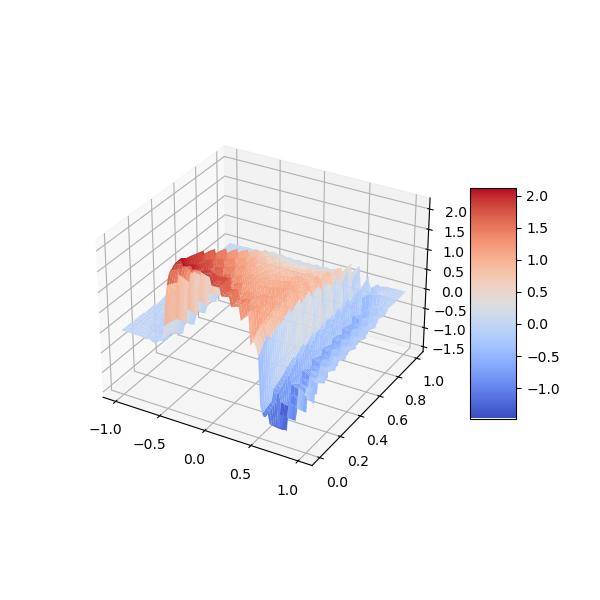

In [18]:
x_sample_points = 100
y_sample_points = 100
X = np.linspace(-1, 1, x_sample_points)
Y = np.linspace(0, 1, y_sample_points)
X, Y = np.meshgrid(X, Y)
Z = np.array([[computed_solution([X[i, j], Y[i, j]]) for j in range(y_sample_points)] for i in range(x_sample_points)])

%matplotlib notebook
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### triangular elements with piecewise quadratic functions:

In [19]:
init = initial_definitions('Triangular', 'Quadratic')
elements, number_of_elements, including_element = init['get_elements'](20, 10)
edge_start_end_reference_element = init['get_start_end_edge_on_reference_element']
global_coordinates = init['get_transform']
local_coordinates = init['get_inverse_transform']
Jacobian = init['get_Jacobian']
integrate = init['get_integrate']
N = init['get_N']
grad_N = init['get_grad_N']
points_per_element = init['get_points_per_element']
points_per_element_boundary = init['get_points_per_element_boundary']
local_edge_node_coordinates = init['get_local_edge_node_coordinates']

connectivity, test_dimension = get_connectivity(elements)

epsilon = 1
K, F = get_discritized_equations()

U = sp.sparse.linalg.spsolve(K, F)


100%|██████████| 400/400 [05:16<00:00,  1.27it/s]


<IPython.core.display.Javascript object>


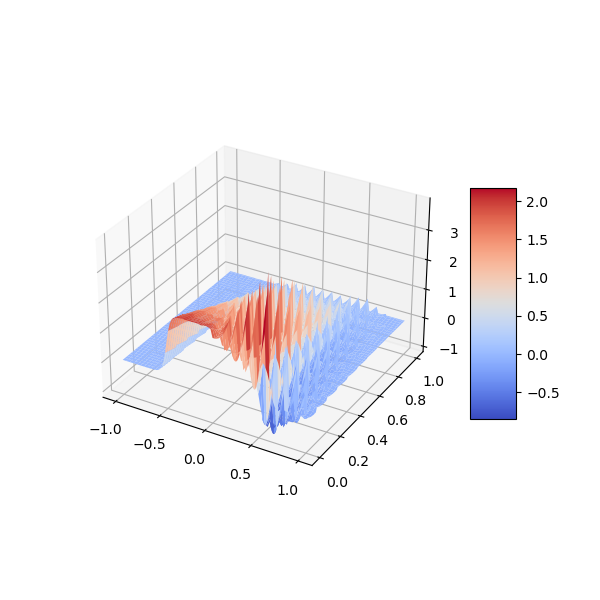

In [20]:
x_sample_points = 100
y_sample_points = 100
X = np.linspace(-1, 1, x_sample_points)
Y = np.linspace(0, 1, y_sample_points)
X, Y = np.meshgrid(X, Y)
Z = np.array([[computed_solution([X[i, j], Y[i, j]]) for j in range(y_sample_points)] for i in range(x_sample_points)])

%matplotlib notebook
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### quadrilateral elements with piecewise bilinear functions:

In [21]:
init = initial_definitions('Quadrilateral', 'Bilinear')
elements, number_of_elements, including_element = init['get_elements'](20, 10)
edge_start_end_reference_element = init['get_start_end_edge_on_reference_element']
global_coordinates = init['get_transform']
local_coordinates = init['get_inverse_transform']
Jacobian = init['get_Jacobian']
integrate = init['get_integrate']
N = init['get_N']
grad_N = init['get_grad_N']
points_per_element = init['get_points_per_element']
points_per_element_boundary = init['get_points_per_element_boundary']
local_edge_node_coordinates = init['get_local_edge_node_coordinates']

connectivity, test_dimension = get_connectivity(elements)

epsilon = 1
K, F = get_discritized_equations()

U = sp.sparse.linalg.spsolve(K, F)


100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


<IPython.core.display.Javascript object>


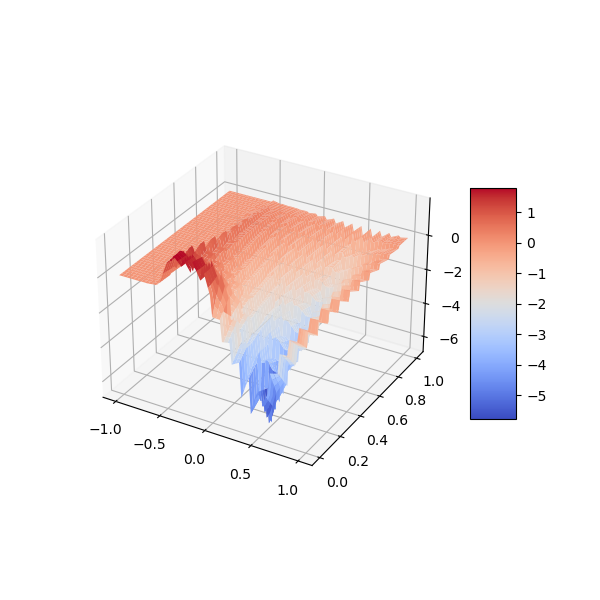

In [22]:
x_sample_points = 100
y_sample_points = 100
X = np.linspace(-1, 1, x_sample_points)
Y = np.linspace(0, 1, y_sample_points)
X, Y = np.meshgrid(X, Y)
Z = np.array([[computed_solution([X[i, j], Y[i, j]]) for j in range(y_sample_points)] for i in range(x_sample_points)])

%matplotlib notebook
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### quadrilateral elements with piecewise biquadratic functions:

In [23]:
init = initial_definitions('Quadrilateral', 'Biquadratic')
elements, number_of_elements, including_element = init['get_elements'](20, 10)
edge_start_end_reference_element = init['get_start_end_edge_on_reference_element']
global_coordinates = init['get_transform']
local_coordinates = init['get_inverse_transform']
Jacobian = init['get_Jacobian']
integrate = init['get_integrate']
N = init['get_N']
grad_N = init['get_grad_N']
points_per_element = init['get_points_per_element']
points_per_element_boundary = init['get_points_per_element_boundary']
local_edge_node_coordinates = init['get_local_edge_node_coordinates']

connectivity, test_dimension = get_connectivity(elements)

epsilon = 1
K, F = get_discritized_equations()

U = sp.sparse.linalg.spsolve(K, F)


100%|██████████| 200/200 [06:45<00:00,  2.03s/it]


<IPython.core.display.Javascript object>


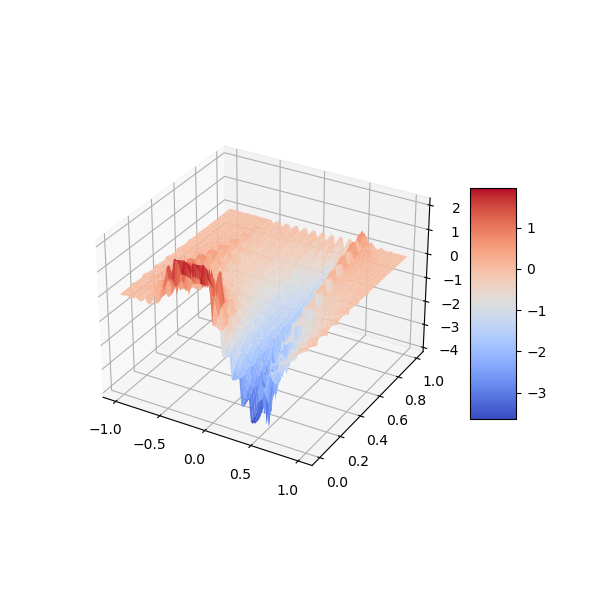

In [24]:
x_sample_points = 100
y_sample_points = 100
X = np.linspace(-1, 1, x_sample_points)
Y = np.linspace(0, 1, y_sample_points)
X, Y = np.meshgrid(X, Y)
Z = np.array([[computed_solution([X[i, j], Y[i, j]]) for j in range(y_sample_points)] for i in range(x_sample_points)])

%matplotlib notebook
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## references:
* Morton, K. W. (2019). Revival: Numerical solution of convection-diffusion problems (1996). CRC Press.
